In [1]:
import torch
import pandas as pd
import numpy as np
import sklearn
from collections import Counter

In [2]:
from sklearn.utils import Bunch
from sklearn.model_selection import train_test_split

In [3]:
from itertools import combinations

In [4]:
import re

# Load Dataset

In [57]:
def get_dataset(df, seed, test_size):
    
    train, test = train_test_split(df, test_size=test_size, random_state=seed, shuffle=True)
    
    return train.tweet.values, train.hate_speech_label.values, test.tweet.values, test.hate_speech_label.values

In [58]:
path = "data/twitter.csv"
df = pd.read_csv(path, index_col=0)
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [59]:
df = df.rename(columns={'class': 'hate_speech_label'})

1    19190
2     4163
0     1430
Name: hate_speech_label, dtype: int64


array([<AxesSubplot:ylabel='hate_speech_label'>], dtype=object)

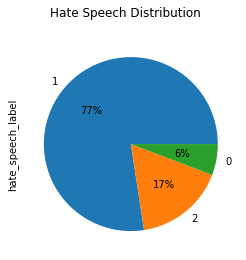

In [60]:
print(df.hate_speech_label.value_counts())
df.hate_speech_label.value_counts().plot(kind='pie', subplots=True, autopct='%1.0f%%', title='Hate Speech Distribution')

## Data Cleansing

In [61]:
def filter_hatespeech_tweets(df):
    
    def filter_tweets(tweet):
        tweet = re.sub('@.\:|!|@\w+|&#[0-9]*;|#\w+|RT|\/\/t.co\/\w+|&gt|&lt', '', tweet)
        if tweet[0:4] == '  : ':
            tweet = tweet[4:]
        return tweet

    df['tweet'] = df['tweet'].apply(filter_tweets)
    df.replace("", np.nan, inplace=True)
    df = df.dropna()
    
    return df

In [62]:
df = filter_hatespeech_tweets(df)
df = filter_hatespeech_tweets(df)

In [63]:
df.head()

,count,hate_speech,offensive_language,neither,hate_speech_label,tweet
0,3,0,0,3,2,As a woman you shouldn't complain about cleani...
1,3,0,3,0,1,boy dats cold...tyga dwn bad for cuffin dat ho...
2,3,0,3,0,1,Dawg : You ever fuck a bitch and she start...
3,3,0,2,1,1,she look like a tranny
4,6,0,6,0,1,The shit you hear about me might be true or it...


In [65]:
df.tweet

0        As a woman you shouldn't complain about cleani...
1        boy dats cold...tyga dwn bad for cuffin dat ho...
2           Dawg  : You ever fuck a bitch and she start...
3                                   she look like a tranny
4        The shit you hear about me might be true or it...
                               ...                        
25291    you's a muthaf***in lie :   right His TL is tr...
25292    you've gone and broke the wrong heart baby, an...
25294    young buck wanna eat.. dat nigguh like I aint ...
25295                youu got wild bitches tellin you lies
25296    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 24782, dtype: object

In [12]:
categories = [0,1,2]
class_1 = 0
class_2 = 1
class_3 = 2
seed = 11
test_size = 0.2

In [13]:
train, train_targets, test, test_targets = get_dataset(df, seed=seed, test_size=test_size)

In [14]:
len(train_targets)

19825

In [15]:
len(train)

19825

In [16]:
train_size = len(train)
test_size = len(test)
print(train_size, test_size)

19825 4957


In [17]:
def calculate_dataset_class_distribution(targets, categories):
    df = pd.DataFrame({'category':targets})
    s = df.category.value_counts(normalize=True)
    s = s.reindex(categories)
    return [s.index[0], s[0]], [s.index[1], s[1], s.index[2], s[2]]

In [18]:
train_class_distribution = calculate_dataset_class_distribution(train_targets, categories)
test_class_distribution = calculate_dataset_class_distribution(test_targets, categories)

In [19]:
newsgroups_train = Bunch(data=train, target=train_targets)
newsgroups_test = Bunch(data=test, target=test_targets)

In [20]:
# Getting all the vocabularies and indexing to a unique position
vocab = Counter()
#Indexing words from the training data
for text in newsgroups_train.data:
    for word in text.split(' '):
        vocab[word.lower()]+=1

#Indexing words from the training data
for text in newsgroups_test.data:
    for word in text.split(' '):
        vocab[word.lower()]+=1

total_words = len(vocab)

def get_word_2_index(vocab):
    word2index = {}
    for i,word in enumerate(vocab):
        word2index[word.lower()] = i

    return word2index

word2index = get_word_2_index(vocab)

In [21]:
print(len(word2index))
print(word2index["the"]) # Showing the index of 'the'
print (total_words)

31465
137
31465


In [22]:
def get_batch(df,i,batch_size):
    batches = []
    results = []
    # Split into different batchs, get the next batch 
    texts = df.data[i*batch_size:i*batch_size+batch_size]
    # get the targets 
    categories = df.target[i*batch_size:i*batch_size+batch_size]
    #print(categories)
    for text in texts:
        # Dimension, 196609
        layer = np.zeros(total_words,dtype=float)

        for word in text.split(' '):
            layer[word2index[word.lower()]] += 1
        batches.append(layer)

    # We have 5 categories
    for category in categories:
        #print(category)
        index_y = -1
        if category == 0:
            index_y = 0
        elif category == 1:
            index_y = 1
        elif category == 2:
            index_y = 2
        results.append(index_y)

    # the training and the targets
    return np.array(batches),np.array(results)

In [23]:
# Parameters
learning_rate = 0.001
num_epochs = 8
batch_size = 32
display_step = 10 # ADDED will multiplied by 10

# Network Parameters
hidden_size = 100      # 1st layer and 2nd layer number of features
input_size = total_words # Words in vocab
num_classes = len(categories)         # Categories: "graphics","space","baseball","guns", "christian"

In [24]:
import torch.nn as nn

In [25]:
# define the network
class News_20_Net(nn.Module):
     def __init__(self, input_size, hidden_size, num_classes):
        super(News_20_Net, self).__init__()
        self.layer_1 = nn.Linear(input_size,hidden_size, bias=True).cuda()
        self.relu = nn.ReLU().cuda()
        self.layer_2 = nn.Linear(hidden_size, hidden_size, bias=True).cuda()
        self.output_layer = nn.Linear(hidden_size, num_classes, bias=True).cuda()
    # accept input and return an output
     def forward(self, x):
        out = self.layer_1(x)
        out = self.relu(out)
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.output_layer(out)
        return out

In [26]:
results = []

In [27]:
news_net = News_20_Net(input_size, hidden_size, num_classes)
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()  # This includes the Softmax loss function
optimizer = torch.optim.Adam(news_net.parameters(), lr=learning_rate)  

# Train the Model
for epoch in range(num_epochs):
    # determine the number of min-batches based on the batch size and size of training data
    total_batch = int(len(newsgroups_train.data)/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_x,batch_y = get_batch(newsgroups_train,i,batch_size)
        
        articles = torch.cuda.FloatTensor(batch_x, device='cuda')
        labels = torch.cuda.LongTensor(batch_y, device='cuda')

        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = news_net(articles)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % display_step == 0:
            result = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f'%(epoch+1, num_epochs, i+1, len(newsgroups_train.data)/batch_size, loss.data)
            results.append({'Epoch': epoch+1, 'Step': i+1, 'Loss': loss.data.item()})
            if (i+1) % (display_step*10) == 0:
                print({'Epoch': epoch+1, 'Step': i+1, 'Loss': loss.data.item()})

{'Epoch': 1, 'Step': 100, 'Loss': 0.39631497859954834}
{'Epoch': 1, 'Step': 200, 'Loss': 0.6101585626602173}
{'Epoch': 1, 'Step': 300, 'Loss': 0.4763084352016449}
{'Epoch': 1, 'Step': 400, 'Loss': 0.535209059715271}
{'Epoch': 1, 'Step': 500, 'Loss': 0.44611087441444397}
{'Epoch': 1, 'Step': 600, 'Loss': 0.2883475720882416}
{'Epoch': 2, 'Step': 100, 'Loss': 0.14694616198539734}
{'Epoch': 2, 'Step': 200, 'Loss': 0.4242000877857208}
{'Epoch': 2, 'Step': 300, 'Loss': 0.1996285766363144}
{'Epoch': 2, 'Step': 400, 'Loss': 0.25541502237319946}
{'Epoch': 2, 'Step': 500, 'Loss': 0.382729172706604}
{'Epoch': 2, 'Step': 600, 'Loss': 0.05549193173646927}
{'Epoch': 3, 'Step': 100, 'Loss': 0.07483301311731339}
{'Epoch': 3, 'Step': 200, 'Loss': 0.3596741855144501}
{'Epoch': 3, 'Step': 300, 'Loss': 0.060641828924417496}
{'Epoch': 3, 'Step': 400, 'Loss': 0.05875125154852867}
{'Epoch': 3, 'Step': 500, 'Loss': 0.197151780128479}
{'Epoch': 3, 'Step': 600, 'Loss': 0.032647956162691116}
{'Epoch': 4, 'Step':

Create Results 

---

In [28]:
# Test the Model
correct = 0
total = 0
total_test_data = len(newsgroups_test.target)

In [29]:
iterates = total_test_data/batch_size # ignore last (<batch_size) batch

In [30]:
all_total = []
all_correct = []
labels_all = []
predicted_all = []

In [31]:
for i in range(int(iterates)):
    batch_x_test,batch_y_test = get_batch(newsgroups_test,i,batch_size)
    articles = torch.FloatTensor(batch_x_test).to('cuda')
    labels = torch.LongTensor(batch_y_test).to('cuda')
    outputs = news_net(articles)
    _, predicted = torch.max(outputs.data, 1)
    
    labels_all.extend([x.item() for x in labels])
    predicted_all.extend([x.item() for x in predicted])

In [32]:
from sklearn.metrics import classification_report

class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

In [33]:
categories = ['hate speech', 'offensive language', 'neither']

In [34]:
report = classification_report(labels_all, predicted_all, target_names=categories, output_dict=True)

In [35]:
df_report = pd.DataFrame(report).transpose()

In [36]:
df_report

,precision,recall,f1-score,support
hate speech,0.454545,0.266667,0.336134,300.000000
offensive language,0.899300,0.940423,0.919402,3827.000000
neither,0.772000,0.722846,0.746615,801.000000
accuracy,0.864042,0.864042,0.864042,0.864042
macro avg,0.708615,0.643312,0.667384,4928.000000
weighted avg,0.851534,0.864042,0.855810,4928.000000


In [37]:
df_results = pd.DataFrame(results)

In [38]:
df_results['learning_rate'] = learning_rate
df_results['num_epochs'] = num_epochs
df_results['batch_size'] = batch_size
df_results['num_classes'] = num_classes
df_results['test_size'] = test_size
df_results['train_size'] = train_size
df_results['seed'] = seed
df_results['test_size'] = test_size
df_results['train_class_distribution_class_1 (' + str(class_1) + ')'] = train_class_distribution[0][1]
df_results['train_class_distribution_class_2 (' + str(class_2) + ')'] = train_class_distribution[1][1]
df_results['test_class_distribution_class_1 (' + str(class_1) + ')'] = test_class_distribution[0][1]
df_results['test_class_distribution_class_2 (' + str(class_2) + ')'] = test_class_distribution[1][1]

In [39]:
df_results.head()

,Epoch,Step,Loss,learning_rate,num_epochs,batch_size,num_classes,test_size,train_size,seed,train_class_distribution_class_1 (0),train_class_distribution_class_2 (1),test_class_distribution_class_1 (0),test_class_distribution_class_2 (1)
0,1,10,1.027178,0.001,8,32,3,4957,19825,11,0.056797,0.773972,0.061327,0.775873
1,1,20,0.765984,0.001,8,32,3,4957,19825,11,0.056797,0.773972,0.061327,0.775873
2,1,30,0.659661,0.001,8,32,3,4957,19825,11,0.056797,0.773972,0.061327,0.775873
3,1,40,0.631391,0.001,8,32,3,4957,19825,11,0.056797,0.773972,0.061327,0.775873
4,1,50,0.720215,0.001,8,32,3,4957,19825,11,0.056797,0.773972,0.061327,0.775873


In [40]:
name = str(class_1) + '_' + str(class_2) + '_results.csv'

In [41]:
df_results.to_csv(name)

In [42]:
name = str(class_1) + '_' + str(class_2) + '_matrix_report.csv'

In [43]:
df_report.to_csv(name)

----